# 3D-BPP

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import sys
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append('src/')
import config, dataset, main, utils, bins


In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


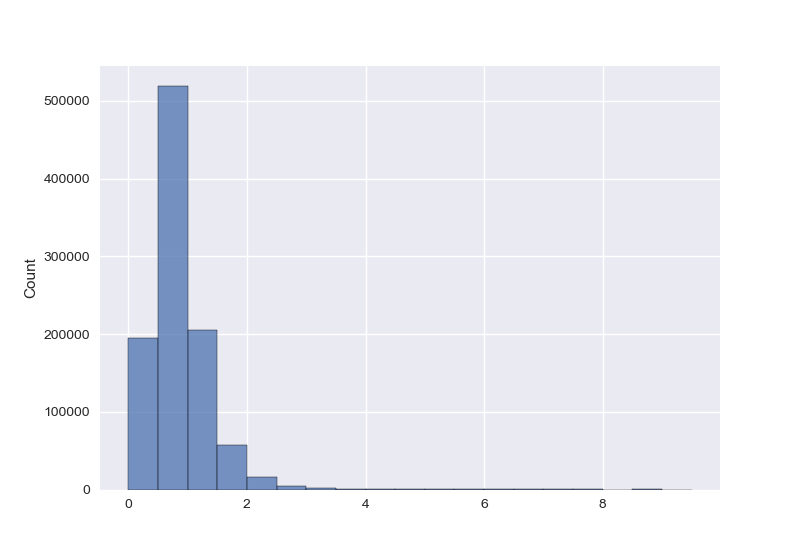

<IPython.core.display.Javascript object>

In [5]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


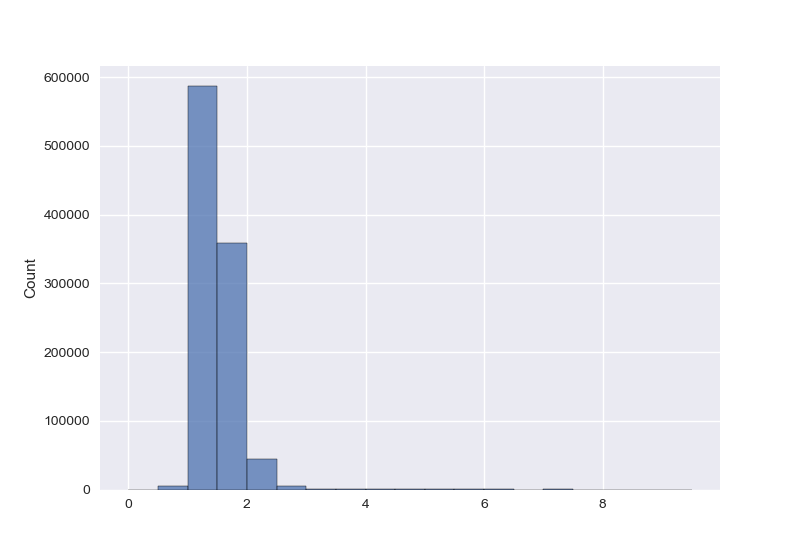

<IPython.core.display.Javascript object>

In [6]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


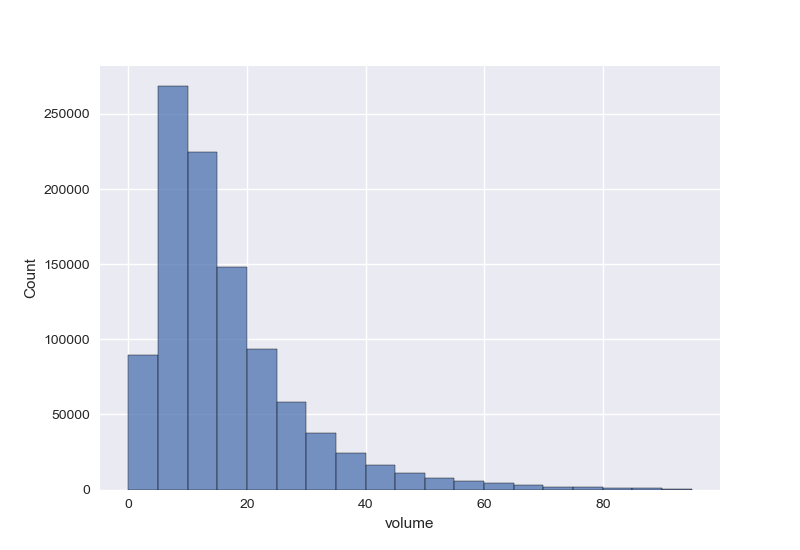

<IPython.core.display.Javascript object>

In [7]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


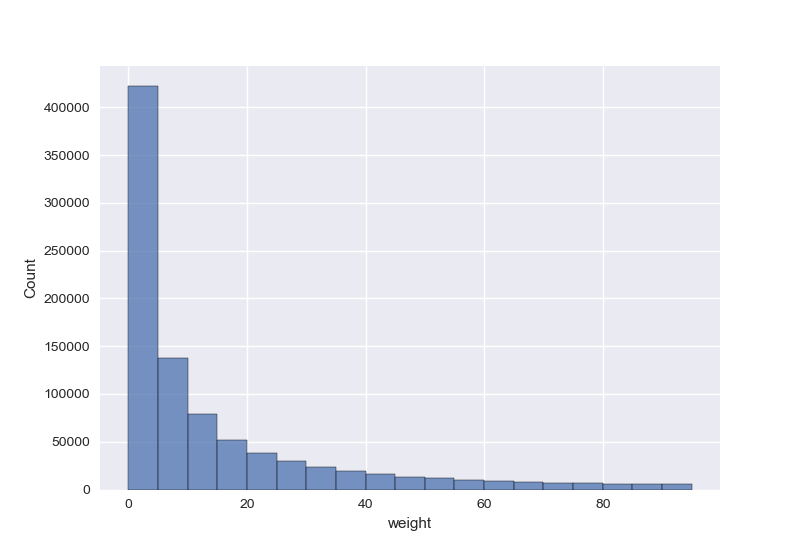

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


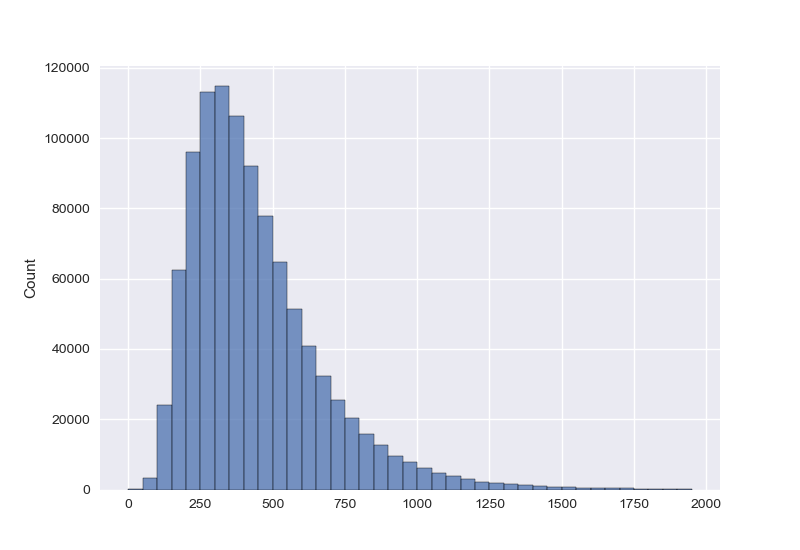

<IPython.core.display.Javascript object>

In [62]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [67]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,392888,236,88,279,8,5794272
1,742092,192,137,254,3,6681216
2,711776,210,96,290,5,5846400
3,877944,272,146,345,10,13700640
4,139830,129,163,187,57,3932049


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [68]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [69]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


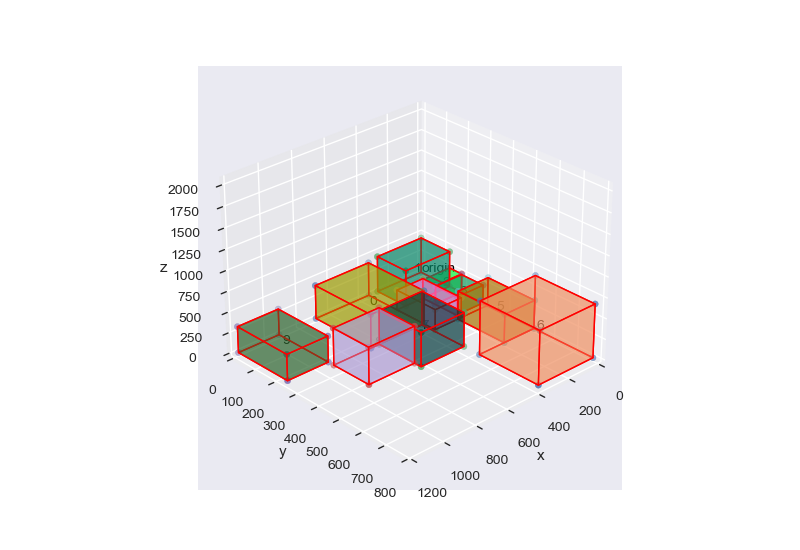

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [7]:
mr_layer_pool = main.maxrect_procedure(order)
mr_layer_pool.to_dataframe()

Generating vertical superitems: 100%|██████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]

Height group 1/8
Height group 2/8
Height group 3/8
Height group 4/8
Height group 5/8
Height group 6/8
Height group 7/8
Height group 8/8
9
Generated 9
Density 8
Coverage 2
Duplicates 2
Empty 2
2
Items not covered: 24/50


,item,x,y,z,width,depth,height,layer
0,20,0,0,0,232,494,441,0
1,21,0,494,0,343,263,411,0
2,7,232,0,0,245,379,394,0
3,36,232,379,0,243,102,406,0
4,39,343,481,0,340,192,413,0
5,19,477,0,0,304,214,406,0
6,28,477,214,0,277,192,416,0
7,41,683,406,0,307,167,422,0
8,11,754,214,0,279,180,437,0
9,22,781,0,0,294,136,440,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


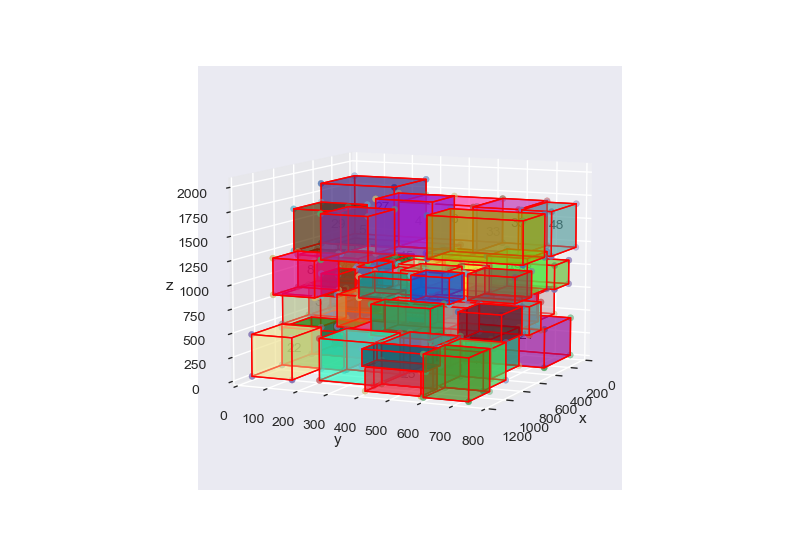

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [8]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

## Column generation

Height group 1/1
Iteration 1/100
Solving RMP...
RMP var  525
RMP constraints  500
RMP iterations  473
RMP objective: 13298.0
Duals: [  0. 360.   0.   0. 295.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 334.   0.   0.   0.   0.   0.   0. 504.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  39.   0.   0.   0.   0. 382.   0.   0.   0.   0.
   0.   0. 196.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 323. 221.   0.   0.   0.   0.   0.   0.
   0. 365.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.  70.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 531.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. 169.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 412.
   0.   0.   0. 

SP placement time: 5.015819309
FEASIBILITY:  18
Solving SP (no placement)...
Feasibility constraint: num selected <= 18
Reward about selecting superitems with duals == 0 0.0009699321047526673
SP_no_placement var  501
SP_no_placement constraints  502
SP_no_placement iterations  6
SP no placement time: 0.042
Reduced cost: -7400.999999999998
Solving SP (with placement)...
SP placement time: 5.02049537
FEASIBILITY:  17
Solving SP (no placement)...
Feasibility constraint: num selected <= 17
Reward about selecting superitems with duals == 0 0.0009699321047526673
SP_no_placement var  501
SP_no_placement constraints  502
SP_no_placement iterations  4
SP no placement time: 0.04
Reduced cost: -7076.0
Solving SP (with placement)...
SP placement time: 1.259156999
New layer: Num selected Items: 17 / 500


<IPython.core.display.Javascript object>


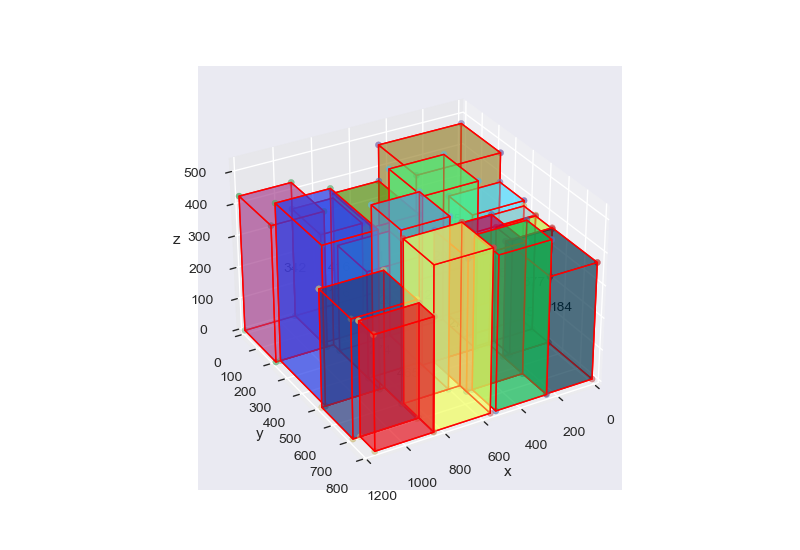

Iteration 2/100
Solving RMP...
RMP var  526
RMP constraints  500
RMP iterations  474
RMP objective: 13298.0
Duals: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 335.   0. 348.   0.   0.   0.   0.   0.   0.  73.   0.   0.
   0.   0.   0.   0. 271.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 271.
 193.   0.   0.   0. 157.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 382.   0.   0. 202.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 333.   0.   0. 523.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 30

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [54]:
filtered_cg_layer_pool, cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(
    order, use_height_groups=False
)
filtered_cg_layer_pool.to_dataframe()

In [ ]:
for i, l in enumerate(cg_layer_pool):
    display(l.to_dataframe())
    print(i)

In [139]:
cg_layer_pool[39].superitems_pool.to_dataframe()

,width,depth,height,ids,type
0,352,259,457,[5],SingleItemSuperitem
1,345,191,446,[0],SingleItemSuperitem
2,345,191,845,"[0, 6]",VerticalSuperitem
3,378,126,489,[9],SingleItemSuperitem
4,330,191,399,[6],SingleItemSuperitem
5,210,182,324,[4],SingleItemSuperitem
6,149,165,246,[16],SingleItemSuperitem
7,135,165,198,[19],SingleItemSuperitem
8,190,181,285,[1],SingleItemSuperitem
9,154,142,266,[13],SingleItemSuperitem


<IPython.core.display.Javascript object>

In [134]:
zsl = cg_layer_pool.get_zsl()[:, 39]

<IPython.core.display.Javascript object>

In [138]:
fsi, _, _ = cg_layer_pool.superitems_pool.get_fsi()
print(fsi.shape)

(31, 20)


<IPython.core.display.Javascript object>

In [140]:
for i in range(20):
    print(sum([fsi[s, i] * zsl[s] for s in range(31)]) <= 1)

False
True
True
True
True
True
False
False
False
True
True
False
False
True
True
True
False
True
True
False


<IPython.core.display.Javascript object>

In [75]:
filtered_cg_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,23,0,0,0,228,379,354,0
1,42,0,379,0,228,316,363,0
2,44,0,695,0,212,96,331,0
3,10,228,0,0,254,208,346,0
4,7,482,0,0,270,183,365,0
5,0,752,0,0,229,214,367,0
6,1,482,183,0,257,167,355,0
7,38,228,208,0,223,191,316,0
8,31,981,0,0,203,192,339,0
9,48,981,192,0,135,280,302,0


<IPython.core.display.Javascript object>

In [40]:
print(filtered_cg_layer_pool.get_densities(two_dims=False))
print(filtered_cg_layer_pool.get_densities(two_dims=True))

[0.6724938890515223]
[0.855096875]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


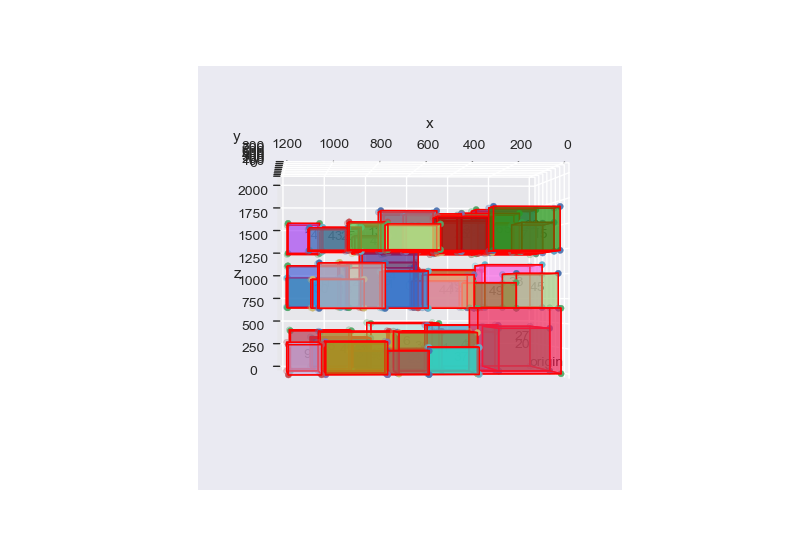

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [10]:
cg_bin_pool = bins.BinPool(filtered_cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

In [ ]:
np.floor(np.mean(cg_bins_lbs) / config.PALLET_HEIGHT)

## Comparison

In [11]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.5825106731014271, 0.5504133117816092, 0.48390885308385306]]

	MR
Bin Heights: [1840]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.742000318877551, 0.5062176748294347, 0.41996953577336643, 0.40269961932976556]


<IPython.core.display.Javascript object>